In [1]:
import netCDF4 as nc
import numpy as np
from pydmd import DMD
from scipy import interpolate
import matplotlib.pyplot as plt
# 

In [2]:
# Paso 1: Leer el archivo NetCDF
datos = nc.Dataset('datos/Land_and_Ocean_EqualArea.nc')

# Suponiendo que 'temperature' es una variable en el archivo
temperaturas = datos.variables['temperature'][:]

# Comprobamos la forma de los datos para entender las dimensiones
print("Forma original de los datos:", temperaturas.shape)


Forma original de los datos: (2089, 15984)


C:\Users\danie\AppData\Local\Temp\ipykernel_12156\218717556.py:5: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  temperaturas = datos.variables['temperature'][:]
C:\Users\danie\AppData\Local\Temp\ipykernel_12156\218717556.py:5: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  temperaturas = datos.variables['temperature'][:]


C:\Users\danie\AppData\Local\Temp\ipykernel_12156\3945478197.py:2: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  temperaturas = datos.variables['temperature'][:]
C:\Users\danie\AppData\Local\Temp\ipykernel_12156\3945478197.py:2: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  temperaturas = datos.variables['temperature'][:]


Forma de los datos de temperatura: (2089, 15984)
Número de modos DMD: 5
Forma de un modo DMD: (2089, 5)


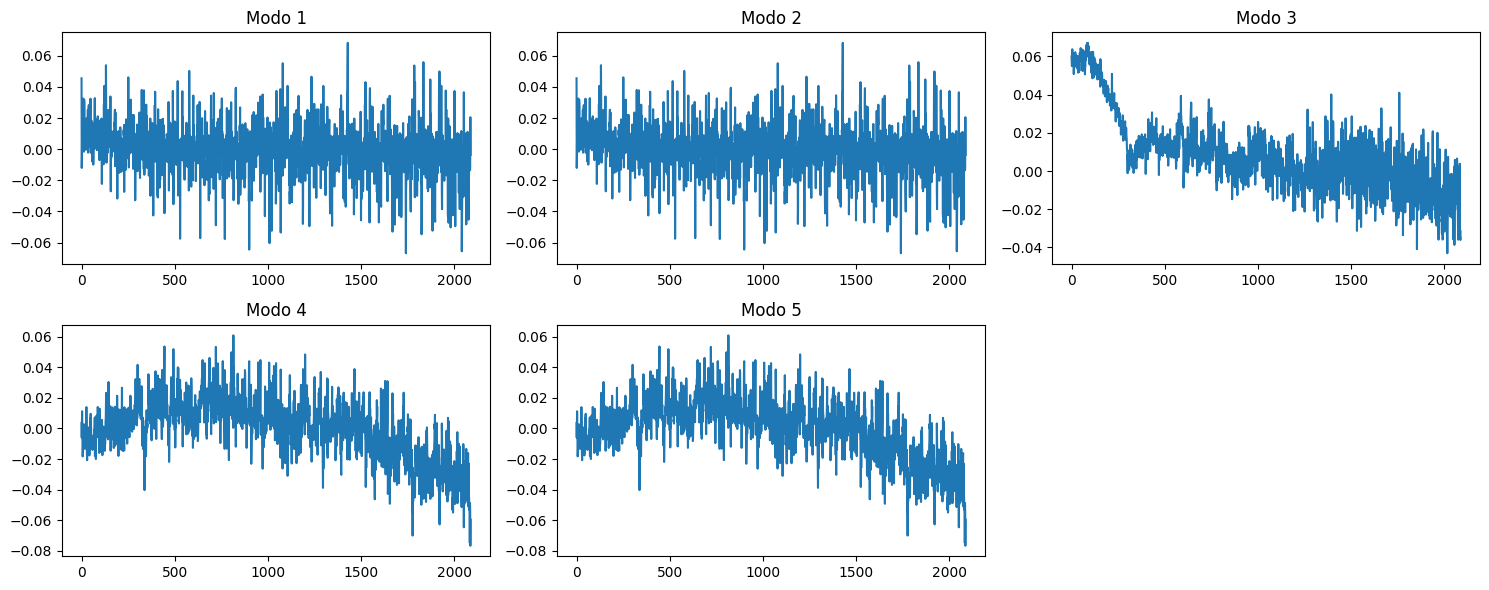

In [3]:

# Suponiendo que 'temperature' es una variable en el archivo
temperaturas = datos.variables['temperature'][:]
print("Forma de los datos de temperatura:", temperaturas.shape)

# Convertir a array de numpy y manejar datos faltantes
temperaturas_np = np.array(temperaturas)
mask = np.isnan(temperaturas_np)

# Rellenar los datos faltantes usando interpolación de valor más cercano
x = np.arange(0, temperaturas_np.shape[0])
y = np.arange(0, temperaturas_np.shape[1])
xx, yy = np.meshgrid(x, y, indexing='ij')

temperaturas_filled = temperaturas_np.copy()
temperaturas_filled[mask] = interpolate.griddata(
    points=(xx[~mask], yy[~mask]),
    values=temperaturas_np[~mask],
    xi=(xx[mask], yy[mask]),
    method='nearest'
)

# Normalización de los datos
temperaturas_normalized = (temperaturas_filled - np.mean(temperaturas_filled)) / np.std(temperaturas_filled)

# Aseguramos que los datos estén en formato 2D (variables x tiempo)
temperaturas_2d = temperaturas_normalized.reshape(-1, temperaturas_normalized.shape[-1])

# Inicializar DMD con parámetros ajustados para la convergencia
dmd = DMD(svd_rank=5, tlsq_rank=0, exact=False)
dmd.fit(temperaturas_2d)  # Aseguramos que los datos estén en formato adecuado

# Imprimir detalles sobre los modos DMD
print("Número de modos DMD:", len(dmd.modes.T))
print("Forma de un modo DMD:", dmd.modes.shape)

# Graficar los modos DMD sin intentar redimensionar
plt.figure(figsize=(15, 6))
for i, mode in enumerate(dmd.modes.T):
    plt.subplot(2, int(np.ceil(len(dmd.modes.T) / 2)), i + 1)
    plt.title(f'Modo {i + 1}')
    plt.plot(mode.real)
    plt.tight_layout()
plt.show()

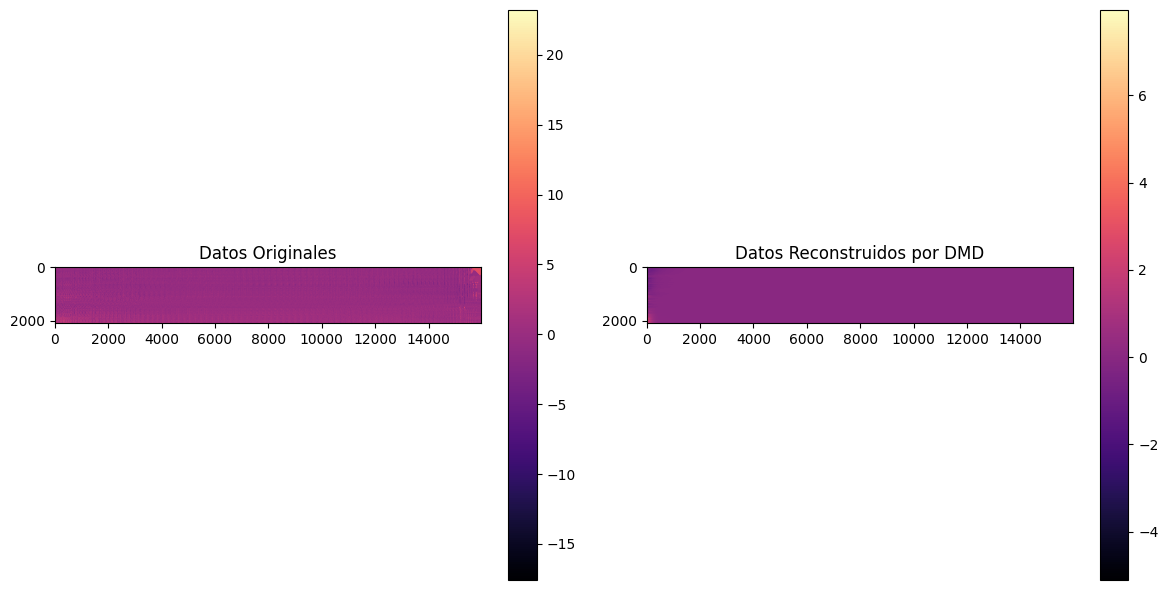

In [4]:
# Reconstrucción de los datos usando DMD
temperaturas_reconstruidas = dmd.reconstructed_data.real

# Denormalizar los datos reconstruidos
temperaturas_reconstruidas_denorm = (temperaturas_reconstruidas * np.std(temperaturas_filled)) + np.mean(temperaturas_filled)

# Comparación visual de los datos originales y reconstruidos
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(temperaturas_filled, cmap='magma')  # Asumiendo que los datos son 2D
plt.title('Datos Originales')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(temperaturas_reconstruidas_denorm.reshape(temperaturas_filled.shape), cmap='magma')
plt.title('Datos Reconstruidos por DMD')
plt.colorbar()

plt.tight_layout()
plt.show()



In [38]:
import netCDF4 as nc
import numpy as np
from pydmd import OptDMD
from scipy import interpolate
import matplotlib.pyplot as plt

# Suponiendo que 'temperature' es una variable en el archivo
temperaturas = datos.variables['temperature'][:]
print("Forma de los datos de temperatura:", temperaturas.shape)

# Convertir a array de numpy y manejar datos faltantes
temperaturas_np = np.array(temperaturas)
mask = np.isnan(temperaturas_np)

# Rellenar los datos faltantes usando interpolación de valor más cercano
x = np.arange(0, temperaturas_np.shape[0])
y = np.arange(0, temperaturas_np.shape[1])
xx, yy = np.meshgrid(x, y, indexing='ij')

temperaturas_filled = temperaturas_np.copy()
temperaturas_filled[mask] = interpolate.griddata(
    points=(xx[~mask], yy[~mask]),
    values=temperaturas_np[~mask],
    xi=(xx[mask], yy[mask]),
    method='nearest'
)

# Normalización de los datos
temperaturas_normalized = (temperaturas_filled - np.mean(temperaturas_filled)) / np.std(temperaturas_filled)

# Aseguramos que los datos estén en formato 2D (variables x tiempo)
temperaturas_2d = temperaturas_normalized.reshape(-1, temperaturas_normalized.shape[-1])

# Inicializar Optimized DMD con parámetros ajustados para la convergencia
opt_dmd = OptDMD(svd_rank=20, tlsq_rank=0, opt=True)
opt_dmd.fit(temperaturas_2d)  # Aseguramos que los datos estén en formato adecuado

# Verificar la disponibilidad de modos y amplitudes
if opt_dmd.modes is None or opt_dmd.amplitudes is None:
    print("Modos o amplitudes no disponibles. Verificar la inicialización y ajuste del modelo.")
else:
    # Reconstrucción manual de los datos
    b = opt_dmd.amplitudes
    omega = opt_dmd.eigs
    vandermonde = np.exp(np.outer(omega, np.arange(temperaturas_2d.shape[1])))
    reconstructed_data = opt_dmd.modes @ (b * vandermonde).T

    # Denormalizar los datos reconstruidos
    temperaturas_reconstruidas_denorm = (reconstructed_data.real * np.std(temperaturas_filled)) + np.mean(temperaturas_filled)

    # Comparación visual de los datos originales y reconstruidos
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(temperaturas_filled, cmap='viridis')  # Asumiendo que los datos son 2D
    plt.title('Datos Originales')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(temperaturas_reconstruidas_denorm.reshape(temperaturas_filled.shape), cmap='viridis')
    plt.title('Datos Reconstruidos por Optimized DMD')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

# Cerrar el archivo
datos.close()


C:\Users\danie\AppData\Local\Temp\ipykernel_12156\3071519093.py:8: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  temperaturas = datos.variables['temperature'][:]
C:\Users\danie\AppData\Local\Temp\ipykernel_12156\3071519093.py:8: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  temperaturas = datos.variables['temperature'][:]


Forma de los datos de temperatura: (2089, 15984)
Modos o amplitudes no disponibles. Verificar la inicialización y ajuste del modelo.


C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pydmd\optdmd.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  y[x > rcond] = np.reciprocal(x[x > rcond])


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from pydmd import DMD  # Asumiendo que usamos pydmd; ajustar si se usa OptDMD u otra librería específica

# Carga de datos simulada y preprocesamiento, asegúrate de que estos pasos reflejan tus datos reales
# temperaturas_filled ya ha sido generado por tu proceso de interpolación anterior
temperaturas_normalized = (temperaturas_filled - np.mean(temperaturas_filled)) / np.std(temperaturas_filled)

# Datos en formato 2D (variables x tiempo)
temperaturas_2d = temperaturas_normalized.reshape(-1, temperaturas_normalized.shape[-1])

# Inicialización y aplicación de DMD
dmd = DMD(svd_rank=20)  # Ajustar el rango del SVD según el análisis y datos
dmd.fit(temperaturas_2d)

# Verificar disponibilidad de modos y amplitudes
if dmd.modes is None:
    print("Modos no disponibles. Verificar la inicialización y ajuste del modelo.")
else:
    # Graficar modos DMD
    num_modes = min(10, dmd.modes.shape[1])  # Ajustar para mostrar un número específico de modos
    for i in range(num_modes):
        plt.figure(figsize=(12, 6))
        mode = dmd.modes[:, i].reshape(temperaturas_filled.shape[1], temperaturas_filled.shape[2])
        plt.imshow(mode.real, cmap='viridis')  # Usar parte real de los modos
        plt.colorbar()
        plt.title(f'Modo DMD {i + 1}')
        plt.show()


IndexError: tuple index out of range

<Figure size 1200x600 with 0 Axes>

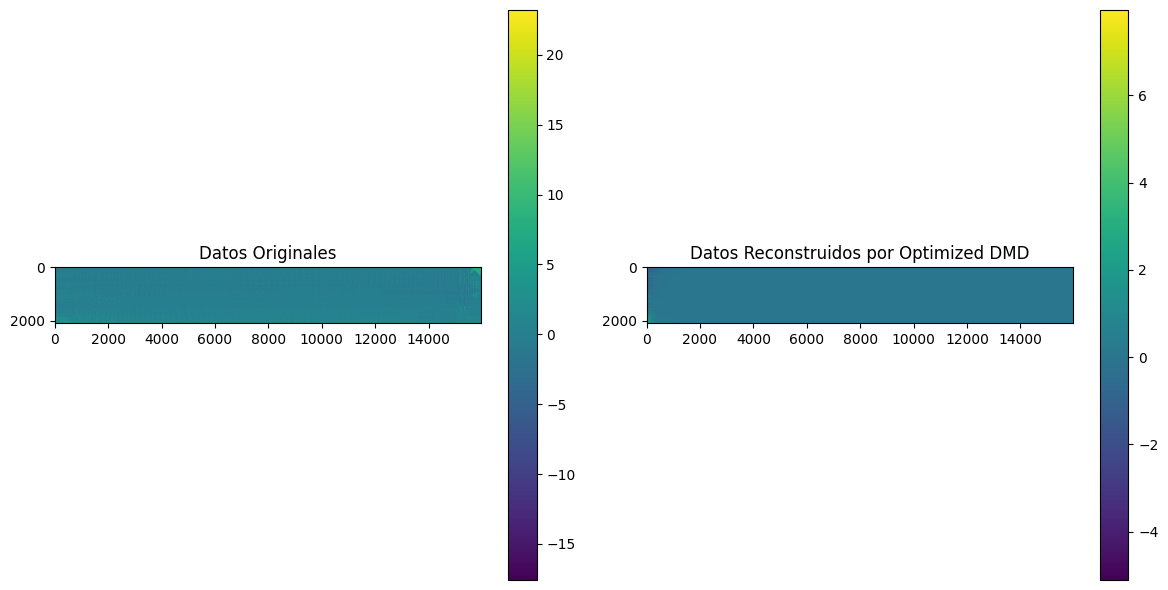

In [37]:
    # Comparación visual de los datos originales y reconstruidos
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(temperaturas_filled, cmap='viridis')  # Asumiendo que los datos son 2D
    plt.title('Datos Originales')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(temperaturas_reconstruidas_denorm.reshape(temperaturas_filled.shape), cmap='viridis')
    plt.title('Datos Reconstruidos por Optimized DMD')
    plt.colorbar()

    plt.tight_layout()

In [7]:
temperaturas_filled

array([[ 0.46475595,  0.46475595,  0.46475595, ...,  7.459419  ,
         7.459419  ,  7.459419  ],
       [-1.4904644 , -1.4904644 , -1.4904644 , ...,  7.459419  ,
         7.459419  ,  7.459419  ],
       [-0.15729383, -0.15729383, -0.15729383, ...,  7.459419  ,
         7.459419  ,  7.459419  ],
       ...,
       [ 2.2751775 ,  1.8952895 ,  1.9799552 , ...,  0.7010728 ,
         0.7979917 ,  0.3351045 ],
       [ 6.9736958 ,  7.07214   ,  7.153173  , ..., -0.39621753,
        -0.61890924, -0.76239705],
       [ 2.2762094 ,  2.031323  ,  2.123713  , ..., -1.9515219 ,
        -2.2443862 , -2.2738068 ]], dtype=float32)

In [8]:
temperaturas_reconstruidas_denorm

array([[ 0.9359076 ,  0.93638326,  0.93649037, ...,  0.02622285,
         0.02622285,  0.02622285],
       [-0.66757998, -0.6713886 , -0.67506722, ...,  0.02622285,
         0.02622285,  0.02622285],
       [-0.53771921, -0.55004258, -0.56227525, ...,  0.02622285,
         0.02622285,  0.02622285],
       ...,
       [ 4.38301851,  4.37149222,  4.35951505, ...,  0.02622285,
         0.02622285,  0.02622285],
       [ 5.57823042,  5.59227607,  5.60534375, ...,  0.02622285,
         0.02622285,  0.02622285],
       [ 2.40827351,  2.42817189,  2.44740741, ...,  0.02622285,
         0.02622285,  0.02622285]])

In [36]:
# Importar las librerías necesarias
import numpy as np
from pydmd import DMD
import matplotlib.pyplot as plt

# Asumamos que 'temperature' es un array 3D: tiempo x latitud x longitud
# Necesitamos reformularlo en una matriz de snapshots donde cada columna es un snapshot en el tiempo
num_time_points = temperatura.shape[0]
snapshots = temperatura.reshape(num_time_points, -1).T  # Transponer para que las columnas sean los snapshots

# Aplicar DMD
dmd = DMD(svd_rank=-1)  # Usar rango completo; ajusta según necesidades específicas
dmd.fit(snapshots)

# Graficar los modos DMD
for i, mode in enumerate(dmd.modes.T):
    plt.figure()
    plt.title(f'Modo DMD {i+1}')
    plt.imshow(mode.reshape(temperatura.shape[1], temperatura.shape[2]), cmap='viridis')
    plt.colorbar()
    plt.show()

# Graficar los valores propios
plt.figure()
plt.title('Espectro de valores propios')
plt.scatter(dmd.eigs.real, dmd.eigs.imag, color='red')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.grid(True)
plt.show()


NameError: name 'temperatura' is not defined

In [9]:
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Crear un imputador para reemplazar los NaN por la media de cada columna
imputer = SimpleImputer(strategy='mean')

# Aplicar la imputación a los datos estandarizados
temperature_imputed = imputer.fit_transform(temperaturas)

# Aplicar de nuevo PCA a los datos imputados
pca = PCA(n_components=10)  # Seleccionar los primeros 10 componentes principales
principal_components_imputed = pca.fit_transform(temperature_imputed)

# Explicar la varianza de nuevo
explained_variance_imputed = pca.explained_variance_ratio_

explained_variance_imputed, principal_components_imputed.shape


(array([0.15746269, 0.08150279, 0.05828105, 0.04931062, 0.0412806 ,
        0.03325273, 0.03081784, 0.0230048 , 0.02118561, 0.01980037],
       dtype=float32),
 (2089, 10))

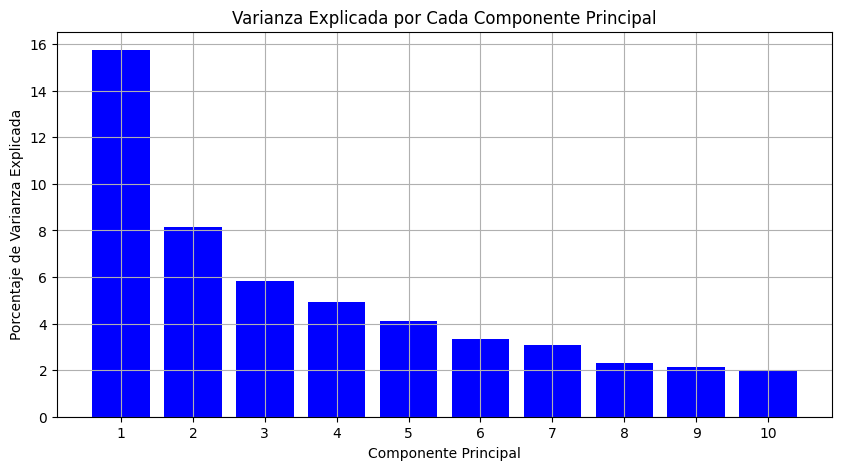

AttributeError: NetCDF: Not a valid ID

In [10]:
import matplotlib.pyplot as plt

# Gráfico de varianza explicada
plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), explained_variance_imputed * 100, color='blue')
plt.xlabel('Componente Principal')
plt.ylabel('Porcentaje de Varianza Explicada')
plt.title('Varianza Explicada por Cada Componente Principal')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# Gráficos de los primeros dos componentes principales
time_points = datos['time'].values[:100]  # Extraer puntos temporales correspondientes

plt.figure(figsize=(15, 7))

# Componente Principal 1
plt.subplot(2, 1, 1)
plt.plot(time_points, principal_components_imputed[:, 0], color='red')
plt.title('Componente Principal 1')
plt.xlabel('Tiempo')
plt.ylabel('Valor del Componente')

# Componente Principal 2
plt.subplot(2, 1, 2)
plt.plot(time_points, principal_components_imputed[:, 1], color='green')
plt.title('Componente Principal 2')
plt.xlabel('Tiempo')
plt.ylabel('Valor del Componente')

plt.tight_layout()
plt.show()


In [12]:
import xarray as xr

# Cargar el archivo NetCDF
data_path = 'datos/Land_and_Ocean_EqualArea.nc'
data = xr.open_dataset(data_path)

# Mostrar la información del dataset
data


<xarray.Dataset> Size: 135MB
Dimensions:      (map_points: 15984, time: 2089, month_number: 12)
Coordinates:
    longitude    (map_points) float32 64kB ...
    latitude     (map_points) float32 64kB ...
  * time         (time) float64 17kB 1.85e+03 1.85e+03 ... 2.024e+03 2.024e+03
Dimensions without coordinates: map_points, month_number
Data variables:
    land_mask    (map_points) float64 128kB ...
    temperature  (time, map_points) float32 134MB ...
    climatology  (month_number, map_points) float32 767kB ...
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               20-Feb-2024 09:56:45
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   07-Feb-2024 05:19:02
    ocean_source_history:  20-Feb-2024 08:20:00
    comment:               This file contains Berkeley Earth surface temperat...

In [17]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Seleccionar la variable de temperatura y convertirla a un numpy array
temperature_data = data['temperature'].values

# Debido a la gran cantidad de datos, se podría considerar un subconjunto para el análisis
# Para este ejemplo, vamos a tomar un subconjunto temporal para simplificar la demostración
temperature_subset = temperature_data  # Tomar los primeros 100 puntos temporales

# Estandarizar los datos
scaler = StandardScaler()
temperature_standardized = scaler.fit_transform(temperature_subset)

# Aplicar PCA
pca = PCA(n_components=10)  # Seleccionar los primeros 10 componentes principales
principal_components = pca.fit_transform(temperature_standardized)

# Explicar la varianza
explained_variance = pca.explained_variance_ratio_

explained_variance, principal_components.shape


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [18]:
from sklearn.impute import SimpleImputer

# Crear un imputador para reemplazar los NaN por la media de cada columna
imputer = SimpleImputer(strategy='mean')

# Aplicar la imputación a los datos estandarizados
temperature_imputed = imputer.fit_transform(temperature_standardized)

# Aplicar de nuevo PCA a los datos imputados
pca = PCA(n_components=10)  # Seleccionar los primeros 10 componentes principales
principal_components_imputed = pca.fit_transform(temperature_imputed)

# Explicar la varianza de nuevo
explained_variance_imputed = pca.explained_variance_ratio_

explained_variance_imputed, principal_components_imputed.shape


(array([0.22670649, 0.05062773, 0.02724869, 0.02036165, 0.01833392,
        0.01636516, 0.01613916, 0.01531723, 0.01385106, 0.01339133],
       dtype=float32),
 (2089, 10))

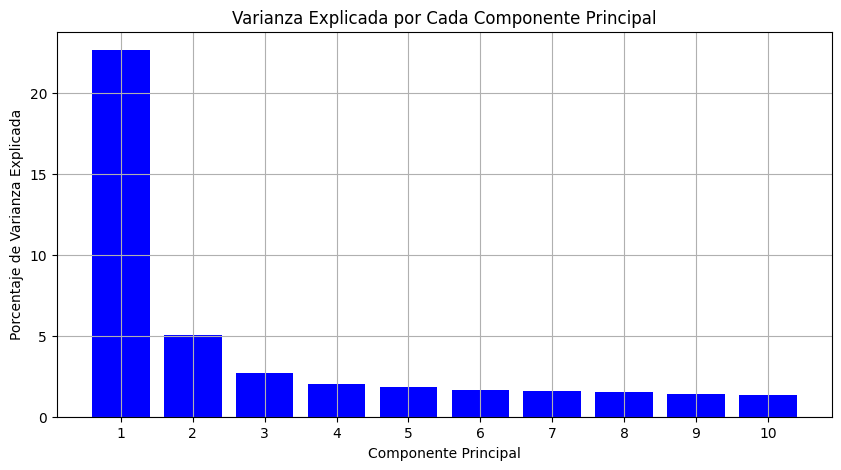

Text(0, 0.5, 'Valor del Componente')

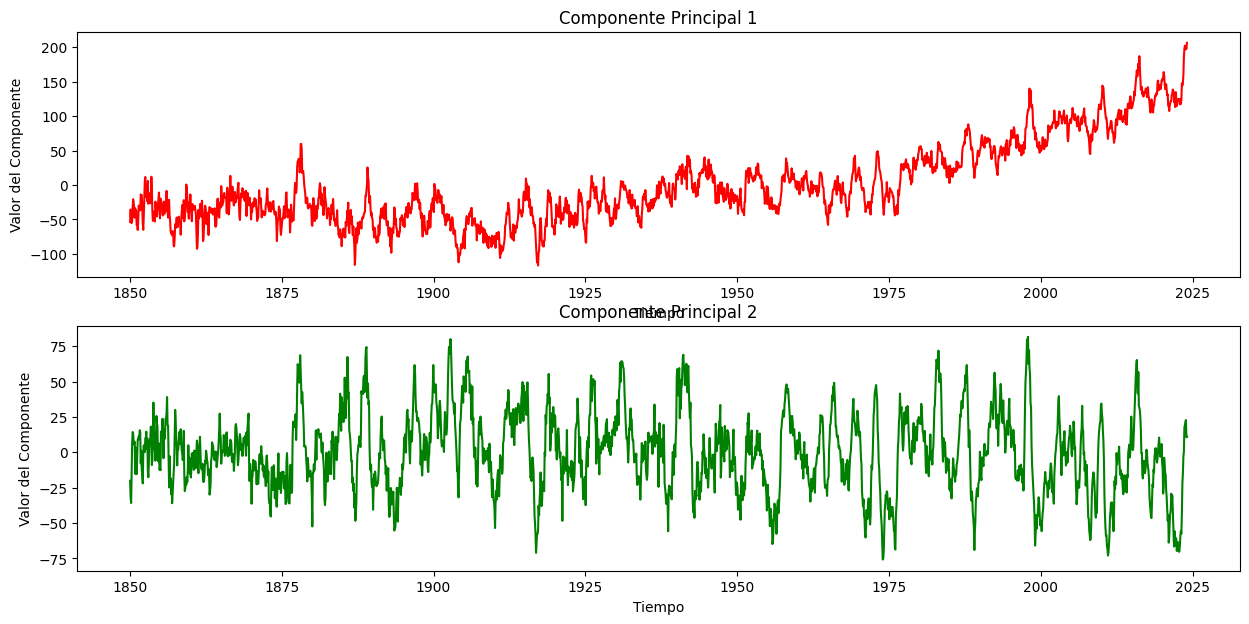

In [32]:
import matplotlib.pyplot as plt

# Gráfico de varianza explicada
plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), explained_variance_imputed * 100, color='blue')
plt.xlabel('Componente Principal')
plt.ylabel('Porcentaje de Varianza Explicada')
plt.title('Varianza Explicada por Cada Componente Principal')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# Gráficos de los primeros dos componentes principales
time_points = data['time'] # Extraer puntos temporales correspondientes

plt.figure(figsize=(15, 7))

# Componente Principal 1
plt.subplot(2, 1, 1)
plt.plot(time_points, principal_components_imputed[:, 0], color='red')
plt.title('Componente Principal 1')
plt.xlabel('Tiempo')
plt.ylabel('Valor del Componente')

# Componente Principal 2
plt.subplot(2, 1, 2)
plt.plot(time_points, principal_components_imputed[:, 1], color='green')
plt.title('Componente Principal 2')
plt.xlabel('Tiempo')
plt.ylabel('Valor del Componente')




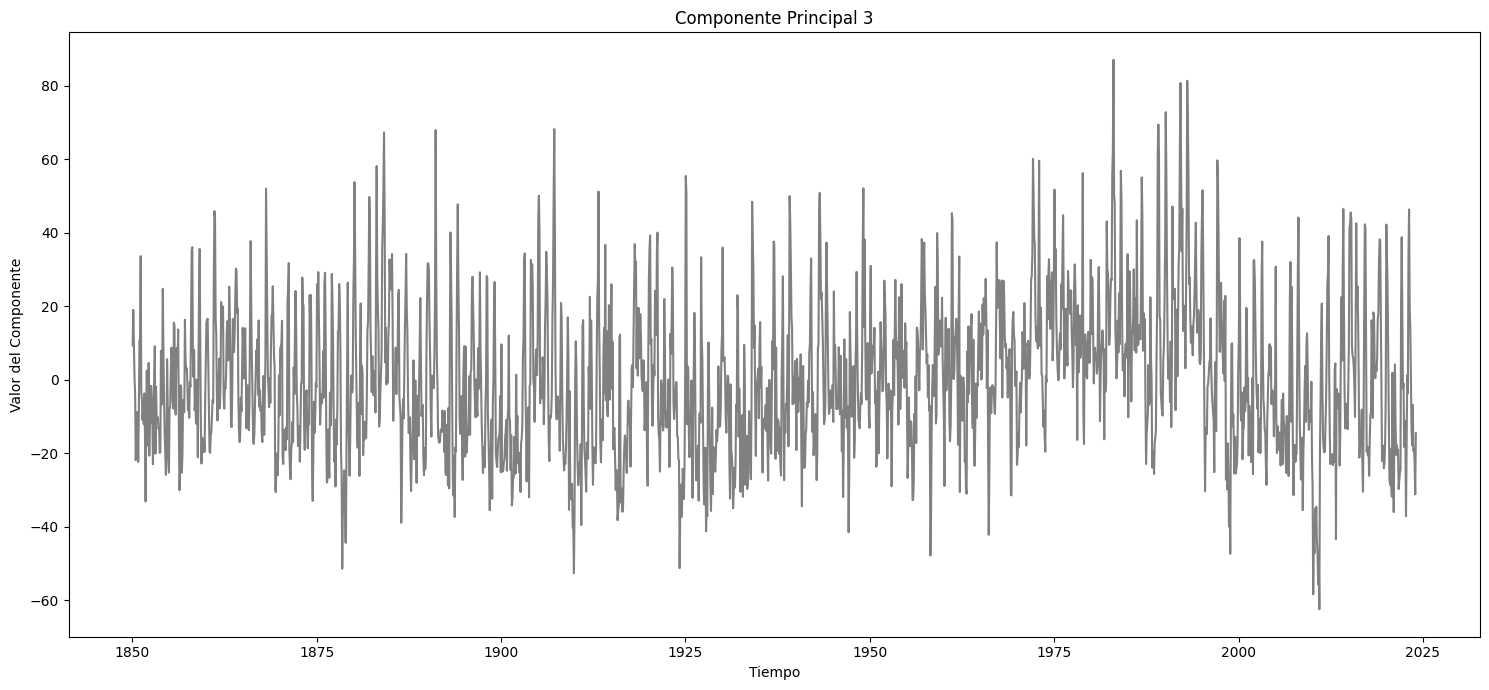

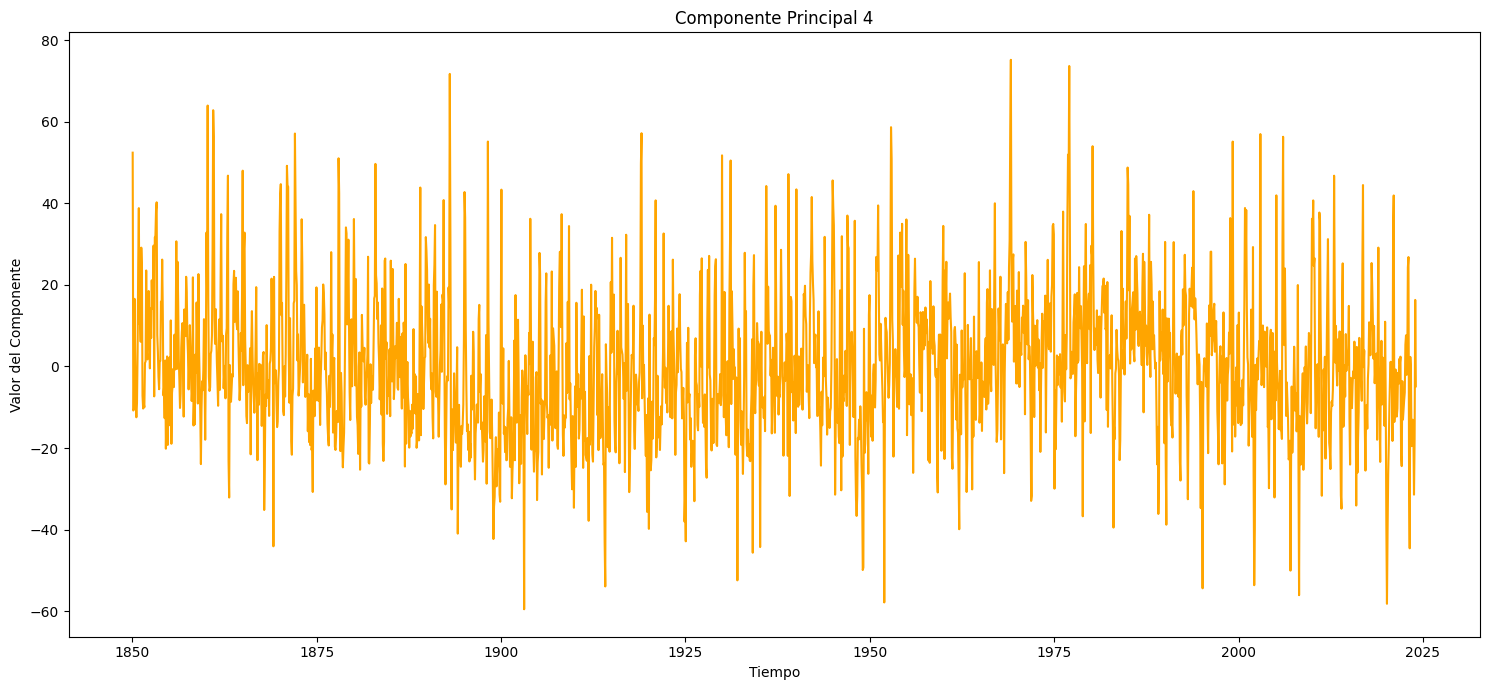

In [35]:
plt.figure(figsize=(15, 7))
plt.plot(time_points, principal_components_imputed[:, 2], color='gray')
plt.title('Componente Principal 3')
plt.xlabel('Tiempo')
plt.ylabel('Valor del Componente')
plt.tight_layout()
plt.show()
plt.figure(figsize=(15, 7))
plt.plot(time_points, principal_components_imputed[:, 3], color='orange')
plt.title('Componente Principal 4')
plt.xlabel('Tiempo')
plt.ylabel('Valor del Componente')
plt.tight_layout()
plt.show()